In [82]:
import numpy as np
import pandas as pd
import tensorflow as tf
# Use this to access file from your Google Drive
from google.colab import drive
drive.mount('/content/drive')
from tensorflow.keras import regularizers, Model
# Use this to split the dataset into training, validation and test
from sklearn.manifold import MDS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix, pairwise_distances, roc_curve, roc_auc_score, auc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [83]:
def apply_preprocess(data):
  # Extract features (X) and target variable (y)
  X = data.iloc[:, :-1]
  y = data.iloc[:, -1]

  # Preproccess the data

  X = X.astype(np.float32)
  y = y.astype(np.float32)

  X = np.array(X)
  y = np.array(y)

  # Standardization
  scaler_standard = StandardScaler()
  X = scaler_standard.fit_transform(X)

  # Convert decimal to integers
  y_integer = [int(y_catagory) for y_catagory in y]

  # Initialize the label encoder
  label_encoder = LabelEncoder()

  # Fit the label encoder to the categories and transform them into integers
  y = label_encoder.fit_transform(y_integer)

  # Split data into training and temporary data (85% train, 15% temp)
  X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

  # Split temporary data into validation and test sets (50% validation, 50% test)
  X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

  return X_train, X_val, X_test, y_train, y_val, y_test

In [84]:
def make_base_model():
  global inputShape
  global loss
  global metric
  global optimizer
  global num_hidden_layer
  global init_layer_width
  global hidden_layer_width
  global activation
  global epochs

  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Dense(init_layer_width, activation=activation, input_shape=(inputShape,)))
  model.add(tf.keras.layers.Dropout(0.2))
  for i in range(num_hidden_layer):
    model.add(tf.keras.layers.Dense(hidden_layer_width, activation=activation))
    model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(3, activation='softmax'))

  model.compile(optimizer=optimizer,
                loss = loss,
                metrics=[metric])

  return model

In [85]:
def make_a_model(inputShape, loss, metric, optimizer, num_hidden_layer, init_layer_width, hidden_layer_width, activation, epoch):
  global epochs
  epochs = epoch

  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Dense(init_layer_width, activation=activation, input_shape=(inputShape,)))
  model.add(tf.keras.layers.Dropout(0.2))
  for i in range(num_hidden_layer):
    model.add(tf.keras.layers.Dense(hidden_layer_width, activation=activation))
    model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(3, activation='softmax'))

  model.compile(optimizer=optimizer,
                loss = loss,
                metrics=[metric])

  return model

In [86]:
def make_models(inputShape = 22):
  global all_metrics
  global all_optimizer
  global all_loss

  num_hidden_layers = [1,2,3,4,6,8,10,14,18]
  models = []
  for num_hidden_layer in num_hidden_layers:
    for _metrics in all_metrics:
      for _optimizer in all_optimizer:
        for _loss in all_loss:

          model = tf.keras.Sequential()
          model.add(tf.keras.layers.Dense(64, activation='relu', input_shape=(inputShape,)))
          model.add(tf.keras.layers.Dropout(0.2))
          for i in range(num_hidden_layer):
            model.add(tf.keras.layers.Dense(32, activation='relu'))
            model.add(tf.keras.layers.Dropout(0.2))
          model.add(tf.keras.layers.Dense(3, activation='softmax'))

          # Compiler
          model.compile(optimizer=_optimizer,
                        loss = _loss,
                        metrics=[_metrics])

          models.append(model)

  return models

In [87]:
def train_models(models, X_train, X_val, y_train, y_val, epoches=None):
  batch_size = 12800

  for model in models:
    # Train all the models
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val))
    print()

  return models

In [88]:
def train_models(models, X_train, X_val, y_train, y_val, epoches):
  batch_size = 12800

  epoch_counter = 0
  for model in models:
    # Train all the models
    history = model.fit(X_train, y_train,
                        epochs=epoches[epoch_counter],
                        batch_size=batch_size,
                        validation_data=(X_val, y_val))

    capture_change_epoch(epoches[epoch_counter], history.history['accuracy'], history.history['val_accuracy'])
    capture_change_epoch_loss(epoches[epoch_counter], history.history['loss'], history.history['val_loss'])
    epoch_counter += 1

    print()

  return models

In [89]:
def capture_change_epoch(epochs, train_acc, val_acc):
  global change_epoch

  change_epoch[epochs] = [train_acc[len(train_acc)-1], val_acc[len(val_acc)-1]]

In [90]:
def capture_change_epoch_loss(epochs, train_loss, val_loss):
  global change_epoch_loss

  change_epoch_loss[epochs] = [train_loss[len(train_loss)-1], val_loss[len(val_loss)-1]]

In [91]:
def capture_change_layer(layer_amount, test_acc, test_loss):
  global change_layer

  change_layer[layer_amount] = [test_acc, test_loss]

In [92]:
def test_models(models, X_test, y_test):
  for model in models:
    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test)

    # F1 Score
    y_pred = model.predict(X_test)

    # Convert probability predictions to discrete class labels
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Classification report on the test set
    test_classification_report = classification_report(y_test, y_pred_labels)
    print("Test Classification Report:")
    print(test_classification_report)

     # Confusion matrix for the validation set
    conf_matrix_val = confusion_matrix(y_val, y_pred_labels)
    print("Confusion Matrix for Validation Set:")
    print(conf_matrix_val)

    # Visualize the confusion matrix for the validation set
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_val, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix for Validation Set')
    plt.show()

    # Confusion matrix for the test set
    conf_matrix_test = confusion_matrix(y_test, y_pred_labels)
    print("Confusion Matrix for Test Set:")
    print(conf_matrix_test)

    # Visualize the confusion matrix for the test set
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_test, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix for Test Set')
    plt.show()

    # Visualize the difference in test accuracy of the nn model vs f1-score
    test_classification_report_dict = classification_report(y_test, y_pred_labels, output_dict=True)
    labels = [0,1,2]
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(labels)), [test_classification_report_dict[str(label)]['f1-score'] for label in labels], color='blue', alpha=0.6, label='F1 Score')
    plt.bar(range(len(labels)), test_accuracy, color='red', alpha=0.6, label='Test Accuracy')
    plt.xlabel('Classes')
    plt.ylabel('Scores')
    plt.xticks(range(len(labels)), labels)
    plt.title('Comparison of F1 Score and Test Accuracy')
    plt.legend()
    plt.show()

    # Compute and Visualize the ROC curve and AUC score
    # Binarize the true labels
    y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])  # Modify classes as per your dataset

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):  # num_classes is the number of classes in your dataset
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(8, 6))
    for i in range(3):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC Curve (Class {i}, AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    # Store change in accuracy and loss
    capture_change_layer(len(model.layers)-2, test_accuracy, test_loss)

In [93]:
# compare elements of all the given arrays to see if they have similar element
# returns true if they do
def check_elements(arrays):
  for array1 in arrays:
    for array2 in arrays:
      if not np.array_equal(array1, array2):
        # Find common elements
        common_elements = np.intersect1d(array1, array2)
        if common_elements.size > 0:
          return True, common_elements, array1, array2
  return False, None, None, None

In [94]:
def apply_model_after_dropping_columns(data):
  # global models
  column_names = data.columns[:-1].tolist()
  for name in column_names:

    new_data = data.drop(columns=[name], inplace=False)

    X_train, X_val, X_test, y_train, y_val, y_test = apply_preprocess(new_data)

    models = make_models(len(new_data.columns.tolist())-1)

    models = train_models(models, X_train, X_val, y_train, y_val)

    print(new_data.columns.tolist())

    test_models(models, X_test, y_test)

In [95]:
def create_train_and_test_model():
  X_train, X_val, X_test, y_train, y_val, y_test = apply_preprocess(df)

  models = make_models(len(df.columns.tolist())-1)

  models = train_models(models, X_train, X_val, y_train, y_val)

  test_models(models, X_test, y_test)

In [96]:
def train_and_test_model(models):
  X_train, X_val, X_test, y_train, y_val, y_test = apply_preprocess(df)

  #models = make_models(len(df.columns.tolist())-1)

  models = train_models(models, X_train, X_val, y_train, y_val)

  test_models(models, X_test, y_test)

In [97]:
def plot_dict(key, value1, value2, value1_label, value2_label, title, xlabel, ylabel):
  plt.figure(figsize=(10, 6))
  plt.plot(key, value1, label=value1_label)
  plt.plot(key, value2, label=value2_label)
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend()
  plt.grid(True)
  plt.show()

In [98]:
# Path to the folder containing the dataset on Google Drive
folder_path = "/content/drive/My Drive/CS4442/Project/smoking_driking_dataset_Ver01.csv"

df = pd.read_csv(folder_path)

In [99]:
# Drop the drink or not column, since we are only doing smoke
df.drop(columns=['DRK_YN'], inplace=True)
df = pd.get_dummies(df, columns=['sex'], drop_first=True)
# Rearrange the columns so that the output is in the last column
desired_columns_order = ['sex_Male', 'age', 'height', 'weight', 'waistline', 'sight_left', 'sight_right', 'hear_left', 'hear_right', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'urine_protein', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'SMK_stat_type_cd']
df = df[desired_columns_order]
# Drop all NA rows in-place
df.dropna(inplace=True)

In [100]:
# Global Variables for basic NN model
inputShape = 22
loss = 'sparse_categorical_crossentropy'
metric = 'accuracy'
optimizer = 'adam'
num_hidden_layer = 1
init_layer_width = 64
hidden_layer_width = 32
activation = 'relu'
epochs = 10

all_loss = ['sparse_categorical_crossentropy']
all_optimizer = ['adam']
all_metrics = ['accuracy']

# The base model
base_model = make_base_model()

# Captures the change
change_epoch = {}
change_epoch_loss = {}
change_layer = {}

66/66 [==============================] - 3s 40ms/step - loss: 0.8667 - accuracy: 0.5871 - val_loss: 0.7018 - val_accuracy: 0.6708

Epoch 1/2
66/66 [==============================] - 3s 31ms/step - loss: 0.8530 - accuracy: 0.5934 - val_loss: 0.7052 - val_accuracy: 0.6703
Epoch 2/2
66/66 [==============================] - 2s 26ms/step - loss: 0.7108 - accuracy: 0.6650 - val_loss: 0.6757 - val_accuracy: 0.6837

Epoch 1/3
66/66 [==============================] - 3s 29ms/step - loss: 0.8165 - accuracy: 0.6244 - val_loss: 0.6870 - val_accuracy: 0.6738
Epoch 2/3
66/66 [==============================] - 2s 26ms/step - loss: 0.7049 - accuracy: 0.6653 - val_loss: 0.6704 - val_accuracy: 0.6871
Epoch 3/3
66/66 [==============================] - 2s 36ms/step - loss: 0.6902 - accuracy: 0.6744 - val_loss: 0.6639 - val_accuracy: 0.6914

Epoch 1/4
66/66 [==============================] - 3s 33ms/step - loss: 0.8081 - accuracy: 0.6277 - val_loss: 0.6899 - val_accuracy: 0.6741
Epoch 2/4
66/66 [==========

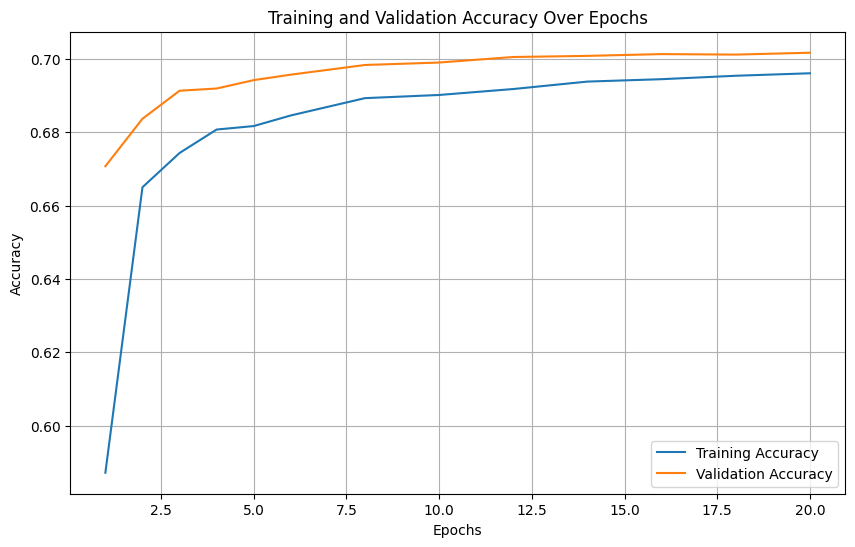

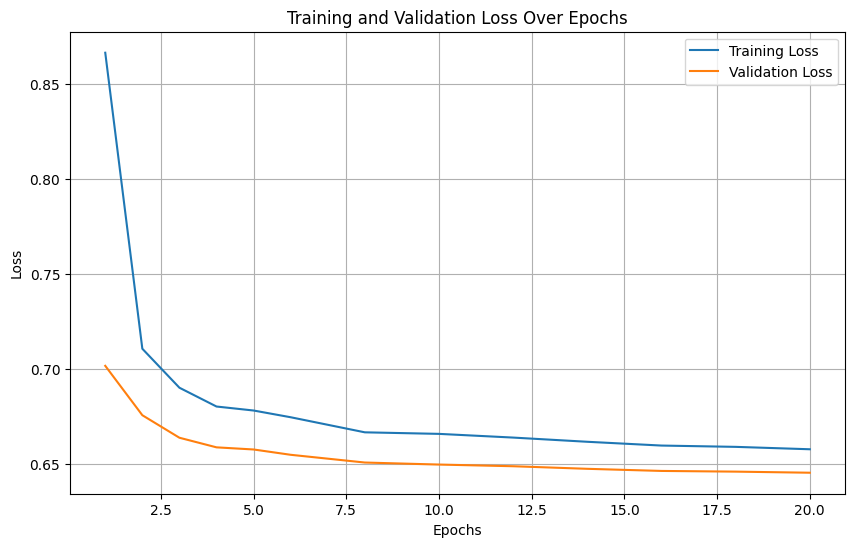

In [101]:
# Train the base model based on different epoch values
X_train, X_val, X_test, y_train, y_val, y_test = apply_preprocess(df)

possible_epochs = [1,2,3,4,5,6,8,10,12,14,16,18,20]
models = []
for ep in possible_epochs:
  models.append(make_base_model())

models = train_models(models, X_train, X_val, y_train, y_val, possible_epochs)

# Extract epochs, training accuracies, and validation accuracies from the dictionary
all_epochs = list(change_epoch.keys())
train_accs = [acc[0] for acc in change_epoch.values()]
val_accs = [acc[1] for acc in change_epoch.values()]

plot_dict(all_epochs, train_accs, val_accs, 'Training Accuracy', 'Validation Accuracy', 'Training and Validation Accuracy Over Epochs', 'Epochs', 'Accuracy')

# Extract epochs, training accuracies, and validation accuracies from the dictionary
all_epochs_loss = list(change_epoch_loss.keys())
train_loss = [acc[0] for acc in change_epoch_loss.values()]
val_loss = [acc[1] for acc in change_epoch_loss.values()]

plot_dict(all_epochs_loss, train_loss, val_loss, 'Training Loss', 'Validation Loss', 'Training and Validation Loss Over Epochs', 'Epochs', 'Loss')
models = make_models()

models = train_models(models, X_train, X_val, y_train, y_val)

#model = make_a_model(22, 'sparse_categorical_crossentropy', 'accuracy', 'adam', 10, 64, 32, 'relu',10)
#train_and_test_model([model])
#create_train_and_test_model()
#apply_model_after_dropping_columns(df)

In [102]:
# Create a model to extract activations
activation_model = Model(inputs=models[len(models)-1].input,
                         outputs=[layer.output for layer in models[len(models)-1].layers[:-1]])

subset_size = 200

# Randomly select a subset of the data
subset_indices = np.random.choice(len(X_test), size=subset_size, replace=False)
subset_X = X_test[subset_indices]
subset_y = y_test[subset_indices]
# Get activations for the dataset
activations = activation_model.predict(subset_X)

7/7 [==============================] - 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_st

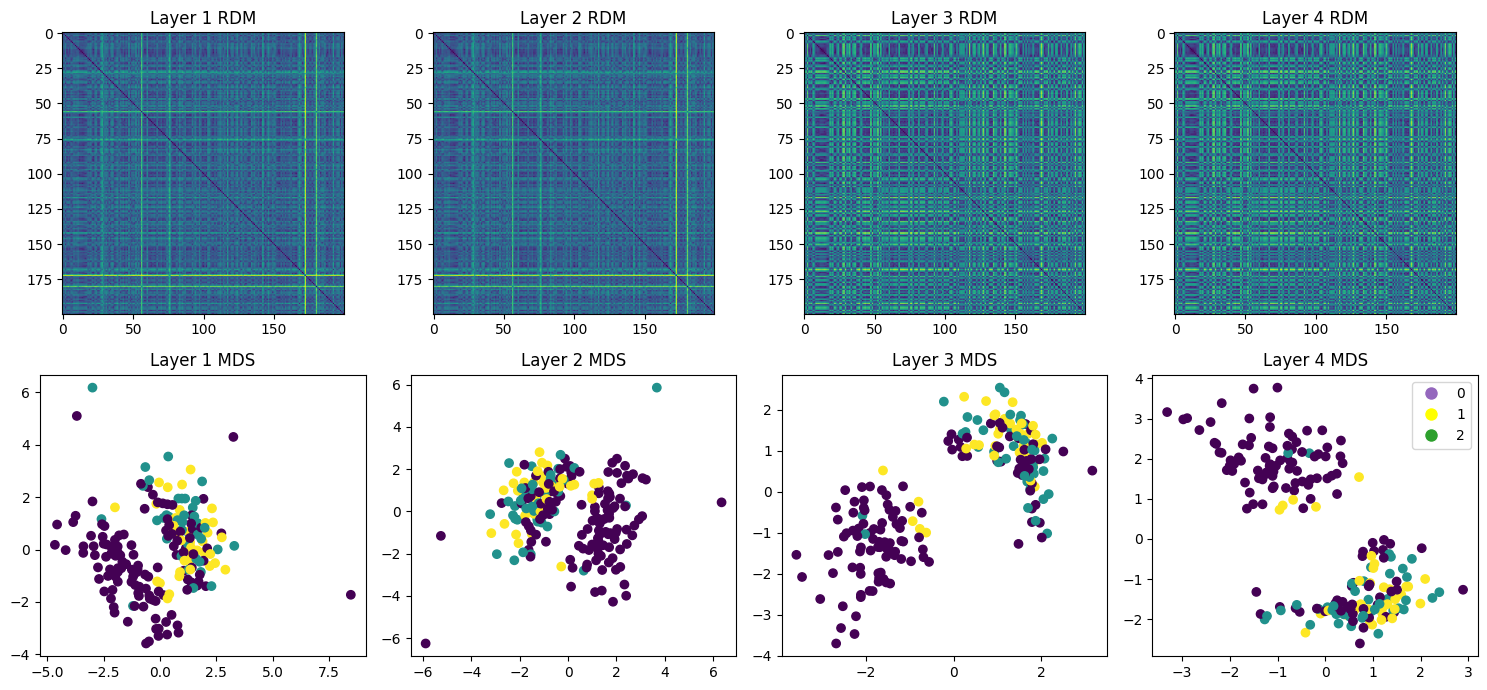

In [143]:
# Create a custom legend
legend_elements = [mlines.Line2D([0], [0], marker='o', color='w', label='0', markerfacecolor='tab:purple', markersize=10),
                   mlines.Line2D([0], [0], marker='o', color='w', label='1', markerfacecolor=(1,1,0), markersize=10),
                   mlines.Line2D([0], [0], marker='o', color='w', label='2', markerfacecolor='tab:green', markersize=10)]

# Compute Dissimilarity Matrix for each layer
dissimilarity_matrices = []
for activation in activations:
    dissimilarity_matrix = pairwise_distances(activation, metric='euclidean')
    dissimilarity_matrices.append(dissimilarity_matrix)

# Perform MDS
num_layers = len(dissimilarity_matrices)
fig, axes = plt.subplots(nrows=2, ncols=num_layers, figsize=(15, 7))

for i, dissimilarity_matrix in enumerate(dissimilarity_matrices):
    # Plot Dissimilarity Matrix
    ax = axes[0, i]
    ax.imshow(dissimilarity_matrix, cmap='viridis')
    ax.set_title(f'Layer {i+1} RDM')

    # Compute MDS
    mds = MDS(n_components=2, dissimilarity='precomputed')
    embedding = mds.fit_transform(dissimilarity_matrix)

    # Plot MDS
    ax = axes[1, i]
    ax.scatter(embedding[:, 0], embedding[:, 1], c=subset_y, cmap='viridis')
    ax.set_title(f'Layer {i+1} MDS')

plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

2324/2324 [==============================] - 3s 1ms/step
Test Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83     45183
           1       0.44      0.41      0.43     13122
           2       0.52      0.59      0.55     16046

    accuracy                           0.70     74351
   macro avg       0.60      0.61      0.60     74351
weighted avg       0.70      0.70      0.70     74351

Confusion Matrix for Validation Set:
[[26738  7377 11068]
 [ 7920  2035  3166]
 [ 9329  2751  3967]]


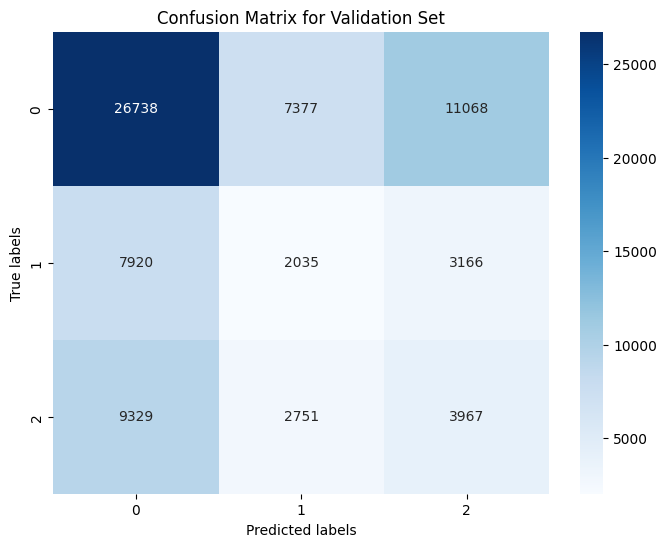

Confusion Matrix for Test Set:
[[37150  3806  4227]
 [ 3241  5374  4507]
 [ 3596  2983  9467]]


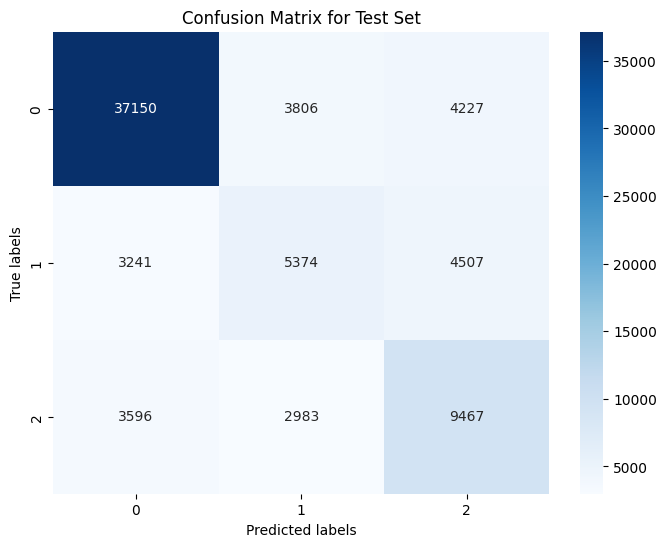

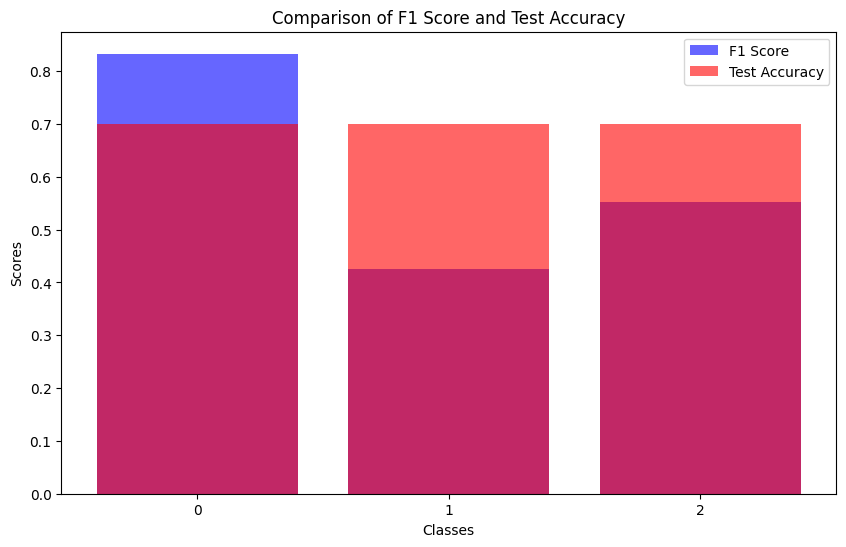

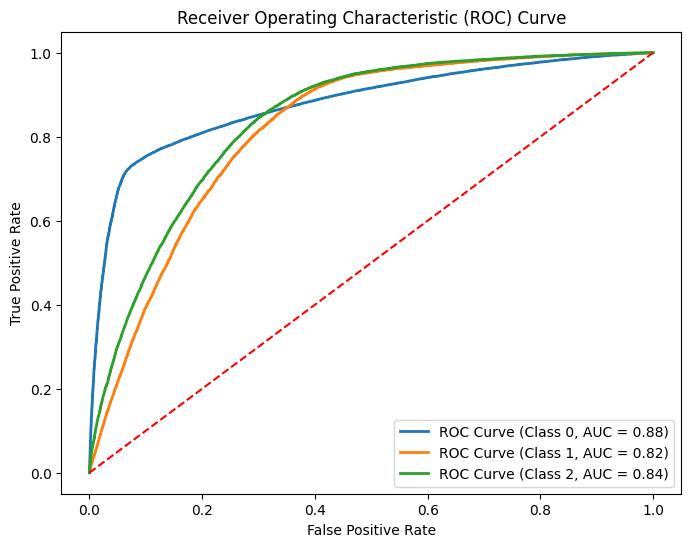

In [104]:
test_models([models[-1]], X_test, y_test)

In [105]:
models[-1].summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_123 (Dense)           (None, 64)                1472      
                                                                 
 dropout_82 (Dropout)        (None, 64)                0         
                                                                 
 dense_124 (Dense)           (None, 32)                2080      
                                                                 
 dropout_83 (Dropout)        (None, 32)                0         
                                                                 
 dense_125 (Dense)           (None, 3)                 99        
                                                                 
Total params: 3651 (14.26 KB)
Trainable params: 3651 (14.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = apply_preprocess(df)

# Train a RandomForestClassifier on the preprocessed training data
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on the validation data
y_val_pred = clf.predict(X_val)

# Evaluate the model on the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy}")

# Classification report on the validation set
val_classification_report = classification_report(y_val, y_val_pred)
print("Validation Classification Report:")
print(val_classification_report)

# Predict on the test data
y_test_pred = clf.predict(X_test)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")

# Classification report on the test set
test_classification_report = classification_report(y_test, y_test_pred)
print("Test Classification Report:")
print(test_classification_report)

# Confusion matrix for the validation set
conf_matrix_val = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix for Validation Set:")
print(conf_matrix_val)

# Visualize the confusion matrix for the validation set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Validation Set')
plt.show()

# Confusion matrix for the test set
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix for Test Set:")
print(conf_matrix_test)

# Visualize the confusion matrix for the test set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Test Set')
plt.show()

[[1 0 0]
 [1 0 0]
 [1 0 0]
 ...
 [0 1 0]
 [0 1 0]
 [1 0 0]]
[[1 0 0]
 [1 0 0]
 [1 0 0]
 ...
 [0 1 0]
 [0 1 0]
 [1 0 0]]


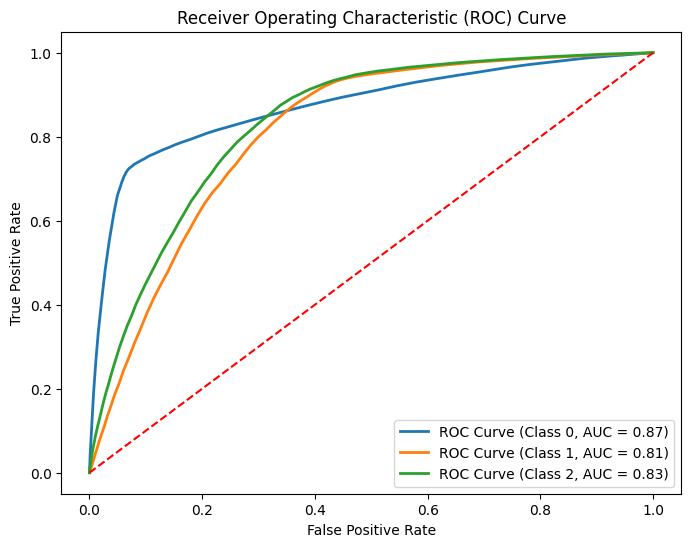

In [127]:
# Compute and Visualize the ROC curve and AUC score
# Binarize the true labels
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])  # Modify classes as per your dataset

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Predict probabilities on the validation data
y_test_pred_proba = clf.predict_proba(X_test)

y_test_pred_binarized = label_binarize(y_test_pred, classes=[0,1,2])
print(y_test_binarized)
print(y_test_pred_binarized)
for i in range(3):  # num_classes is the number of classes in your dataset
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_test_pred_proba[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC Curve (Class {i}, AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

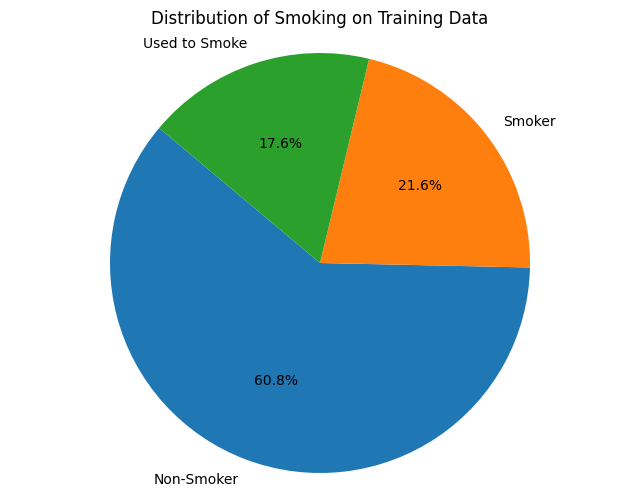

In [142]:
# Data Analysis
column_data = y_train

# Define a dictionary to map numerical values to strings
value_labels = {0: 'Non-Smoker', 1: 'Used to Smoke', 2: 'Smoker'}

# Convert numerical values to their corresponding strings
column_labels = [value_labels[val] for val in column_data]

# Count the occurrences of each unique value in the column
unique_labels, label_counts = np.unique(column_labels, return_counts=True)

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(label_counts, labels=unique_labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Smoking on Training Data')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()